![](images/person-holds-a-basket-full-of-groceries-in-a-supermarket.jpg)

In this project I used the K-means algorithm to cluster grocery items based on their transaction data.

**Items that are often purchases together can be placed in the same aisle or aisles closer to each other,
increasing sales!**

This used to be done by human experts, which would require **many years of experience** in the industry to
narrow things down. However, with the rise of big data and machine learning, why not
let AI do all the trick and hard work for you?

Ok let's get started. The first step is to gather the dataset. Here I downloaded
[the Instacart dataset](https://www.kaggle.com/c/instacart-market-basket-analysis/data)
from Kaggle, and **filtered out items that don't have a sufficient purchase history** yet in the dataset
(being purchased fewer than 100 times), because they may not contain enough information to be correctly
classified(i.e. they may end up forming weird 1-item categories).

In [1]:
# Load dependencies
import pandas as pd
from scipy import sparse
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from utility.jupyter import hide_toggle
pd.set_option('display.max_rows', 30)

# Load the Instacart data and cluster items that have been purchased at least 100 times
df = pd.read_csv('data/order_products__train.csv')
df = df.drop(['add_to_cart_order', 'reordered'], axis=1)
df = df.groupby('product_id').filter(lambda x:len(x) >= 100)

df_products = pd.read_csv('data/products.csv')
df_aisles = pd.read_csv('data/aisles.csv')

hide_toggle()

The main table is pretty straightforward, classical order_id - product_id pairs.

In [2]:
df.head()

,order_id,product_id
1,1,11109
2,1,10246
3,1,49683
5,1,13176
6,1,47209


Now let's transform the order data into a matrix where:
- each row is an order
- each column is a product
- each value 1 indicates a purchase

In [3]:
df['filler'] = 1
df = df.pivot(index='order_id', columns='product_id', values='filler').fillna(0)

hide_toggle()

In [4]:
df.head()

product_id,10,34,45,79,95,116,117,130,141,160,...,49481,49517,49520,49533,49585,49605,49610,49621,49628,49683
order_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
print('Number of Transactions:', df.shape[0])
print('Number of Items:', df.shape[1])

Number of Transactions: 125956
Number of Items: 2457


Cool, now that everything has been set up, let's transform the data into a **similarity matrix**.
(here I used the cosine similarity, but other metrics should be fine).

Essentially, items that are often purchased together will have a similarity of 1, whereas
those that have never been purchased together will have a similarity of 0.

In [6]:
# Save memories by converting it to a sparse matrix
data = df.to_numpy()
data_sparse = sparse.csr_matrix(data)
data_clustering = metrics.pairwise.cosine_similarity(data_sparse.T)
data_clustering = sparse.csr_matrix(data_clustering)

hide_toggle()

Then, time to apply the K-means algorithm using the similarity matrix we just obtained!

How do we choose K though? It's usually more subject to the business requirements.
However, here what we can do is to pick a bunch of Ks and look at the inertia plot.
A range between 8 and 20 would probably be a good start since we don't want to make things too complicated.

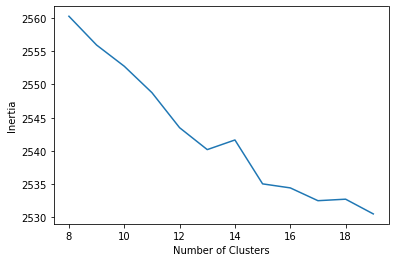

In [7]:
cluster_inertia = []
for i in range(8, 20):
    model = KMeans(n_clusters=i)
    model.fit(data_clustering)
    cluster_inertia.append(model.inertia_)

plt.plot(range(8, 20), cluster_inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

hide_toggle()

According to the plot, 14 seems to be a good choice, since the gains seem to be pretty low as K increases.
Let's now plug in k=14 and get our clusters!

In [8]:
kmeans = KMeans(n_clusters=14)

clusters = kmeans.fit_predict(data_clustering)
final_clusters = pd.DataFrame({'cluster':clusters,
                               'product_id':df.columns})
df_cluster = final_clusters.sort_values('cluster')
df_cluster = pd.merge(df_cluster, df_products, how='left', on='product_id')

hide_toggle()

In [9]:
df_cluster

,cluster,product_id,product_name,aisle_id,department_id
0,0,9881,Vegan Aged White Cheddar Flavor Puffs,107,19
1,0,10108,Artisan Sausage Pineapple Uncured Bacon Hardwo...,24,4
2,0,34124,Organic Low Fat Vegetable Barley Soup,69,15
3,0,10060,Original BBQ Sauce,72,13
4,0,9934,Organic Australian Style Vanilla Lowfat Yogurt,120,16
...,...,...,...,...,...
2452,13,21709,Sparkling Lemon Water,115,7
2453,13,30353,Curate Cherry Lime Sparkling Water,115,7
2454,13,31964,Passionfruit Sparkling Water,115,7
2455,13,22556,All Natural Apricot Sparkling Water,115,7


Get some basic stats regarding our clusters.

In [10]:
df_cluster['cluster'].value_counts()

5     368
1     312
3     309
8     267
0     253
2     216
7     200
9     171
6     135
4     131
11     44
12     19
13     19
10     13
Name: cluster, dtype: int64

The group counts seem quite reasonable. Let's inspect some of the categories manually!

In [11]:
df_cluster.query('cluster == 0').head(20)

,cluster,product_id,product_name,aisle_id,department_id
0,0,9881,Vegan Aged White Cheddar Flavor Puffs,107,19
1,0,10108,Artisan Sausage Pineapple Uncured Bacon Hardwo...,24,4
2,0,34124,Organic Low Fat Vegetable Barley Soup,69,15
3,0,10060,Original BBQ Sauce,72,13
4,0,9934,Organic Australian Style Vanilla Lowfat Yogurt,120,16
5,0,34217,Pesto Tortellini Bowls,38,1
6,0,34458,Vanilla Ice Cream Sandwich,37,1
7,0,9666,Country Morning White Bread,112,3
8,0,9554,Mocha Almond Fudge Minis Almond Milk Frozen De...,37,1
9,0,9507,Honey Turkey Breast,96,20


In [12]:
df_cluster.query('cluster == 1').head(20)

,cluster,product_id,product_name,aisle_id,department_id
253,1,12545,French Vanilla Coconut Milk Creamer,91,16
254,1,46575,Organic Finely Shredded Cheddar Cheese,21,16
255,1,28373,Original Rotisserie Chicken,13,20
256,1,12384,Organic Lactose Free 1% Lowfat Milk,91,16
257,1,31242,Pico De Gallo Chunky Salsa,67,20
258,1,13885,Caramel Cookie Crunch Gelato,37,1
259,1,12464,Muscat Grapes,24,4
260,1,31231,Vitamin Water Zero Rise Orange,64,7
261,1,46650,Special Reserve Extra Sharp Cheddar Cheese,21,16
262,1,30994,Talenti Double Dark Chocolate Gelato,37,1


In [13]:
df_cluster.query('cluster == 5').head(20)

,cluster,product_id,product_name,aisle_id,department_id
1221,5,7969,Lime,24,4
1222,5,8006,Chopped Organic Garlic,110,13
1223,5,8230,100% Recycled Bathroom Tissue,54,17
1224,5,36606,Sprouted Multi-Grain Bread,112,3
1225,5,36550,Organic Extra Large Grade AA Brown Eggs,86,16
1226,5,37011,Artichokes,83,4
1227,5,36389,Organic Rainbow Chard Vegetable,83,4
1228,5,18434,Organic Whole Crimini Mushrooms,83,4
1229,5,16823,Organic Beef Broth,69,15
1230,5,36070,"Super Spinach! Baby Spinach, Baby Bok Choy, Sw...",123,4


In [14]:
df_cluster.query('cluster == 9')

,cluster,product_id,product_name,aisle_id,department_id
2191,9,2180,Angel Hair Pasta,131,9
2192,9,15664,Tomatoes Sauce,81,15
2193,9,19863,Classic Potato Chips,107,19
2194,9,29095,Original Cream Cheese,108,16
2195,9,34234,Grade AA Large White Eggs,86,16
...,...,...,...,...,...
2357,9,36086,Philadelphia Original Cream Cheese,108,16
2358,9,27676,Pinto Beans,59,15
2359,9,4210,Whole Milk,84,16
2360,9,38200,Apple Juice,31,7


In [15]:
df_cluster.query('cluster == 10')

,cluster,product_id,product_name,aisle_id,department_id
2362,10,2596,Lemon Cake Ice Cream,37,1
2363,10,2361,Mint Chip,37,1
2364,10,36029,S'mores Ice Cream,100,21
2365,10,46138,Cookies & Cream Ice Cream,37,1
2366,10,7035,Peanut Butter Ice Cream Cup,100,21
2367,10,31893,Ice Cream Chocolate Mocha Chip,37,1
2368,10,21463,Vanilla Bean Light Ice Cream,37,1
2369,10,17550,Oatneal Cookie Ice Cream,100,21
2370,10,11494,Cookie Dough Ice Cream Chocolate Chip,100,21
2371,10,16965,Chocolate Ice Cream,37,1


Voila! A few interesting discoveries here:
- Category 0 seems to be **raw cooking materials**!
- Category 1 seems to be **organic products and snacks**!
- Category 5 seems to be **organic products** as well!(But they don't seem to be bought together with snacks)
- Category 9 and 100 seem to be two clusters of **low/non-fat dairy products**.

